# Batch (parallel) Demand Forecasting using Prophet, ARIMA, and Ray Tune

**Batch training** and tuning are common tasks in machine learning use-cases. They require training simple models, on data batches, typcially corresponding to different locations, products, etc. Batch training can take less time to process all the data at once, but only if those batches can run in parallel!

This notebook showcases how to conduct batch training using forecast algorithms [Prophet](https://github.com/facebook/prophet) and [ARIMA](https://github.com/Nixtla/statsforecast). **Prophet** is a popular open-source library developed by Facebook and designed for automatic forecasting of univariate time series data. **ARIMA** is an older, well-known algorithm for forecasting univariate time series at less fine-grained detail than Prophet.

![Batch training diagram](../../data/examples/images/batch-training.svg)

For the data, we will use the [NYC Taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). This popular tabular dataset contains historical taxi pickups by timestamp and location in NYC.

For the training, we will train a separate forecasting model to predict #pickups at each location in NYC at daily level for the next 28 days. Specifically, we will use the `pickup_location_id` column in the dataset to group the dataset into data batches. Then we will conduct an experiment for each location, to find the best either Prophet or ARIMA model, per location.

# Contents

In this this tutorial, you will learn how to:
 1. [Define how to load and prepare Parquet data](#prepare_data2)
 2. [Define a Trainable (callable) function](#define_trainable2)
 3. [Run batch training and inference with Ray Tune](#run_tune_search2)
 4. [Load a model from checkpoint](#load_checkpoint2)
 5. [Create a forecast from restored checkpoint model](#create_prediction2)


# Walkthrough

```{tip}
Prerequisite for this notebook: Read the [Key Concepts](https://docs.ray.io/en/latest/tune/key-concepts.html) page for Ray Tune.
```

Let us start by importing a few required libraries, including open-source [Ray](https://github.com/ray-project/ray) itself!

In [1]:
!python --version
import os
num_cpu = os.cpu_count()

print(f"Number of CPUs in this system: {num_cpu}")
from typing import Tuple, List, Union, Optional, Callable
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np

print(f"numpy: {np.__version__}")
import matplotlib.pyplot as plt

%matplotlib inline
import scipy

print(f"scipy: {scipy.__version__}")
import pyarrow
import pyarrow.parquet as pq
import pyarrow.dataset as pds

print(f"pyarrow: {pyarrow.__version__}")

Python 3.8.13
Number of CPUs in this system: 8
numpy: 1.21.6
scipy: 1.9.3
pyarrow: 10.0.0


In [2]:
import ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-01-03 12:15:56,461	INFO worker.py:1230 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2023-01-03 12:15:56,462	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 172.31.207.227:9031...
2023-01-03 12:15:56,501	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at https://console.anyscale-staging.com/api/v2/sessions/ses_b5q8xHd42BTdukSgFqTxejLT/services?redirect_to=dashboard 


Python version:,3.8.13
Ray version:,2.2.0
Dashboard:,http://console.anyscale-staging.com/api/v2/sessions/ses_b5q8xHd42BTdukSgFqTxejLT/services?redirect_to=dashboard


In [3]:
print(ray.cluster_resources())

{'node:172.31.187.140': 1.0, 'memory': 66387570689.0, 'CPU': 24.0, 'object_store_memory': 27597968178.0, 'node:172.31.207.227': 1.0}


In [4]:
# import forecasting libraries
import prophet
from prophet import Prophet

print(f"prophet: {prophet.__version__}")

import statsforecast
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

print(f"statsforecast: {statsforecast.__version__}")

# import ray libraries
from ray import air, tune, serve
from ray.air import session, ScalingConfig
from ray.air.checkpoint import Checkpoint

prophet: 1.0
statsforecast: 1.3.1


In [5]:
# For benchmarking purposes, we can print the times of various operations.
# In order to reduce clutter in the output, this is set to False by default.
PRINT_TIMES = False


def print_time(msg: str):
    if PRINT_TIMES:
        print(msg)


# To speed things up, we’ll only use a small subset of the full dataset consisting of two last months of 2019.
# You can choose to use the full dataset for 2018-2019 by setting the SMOKE_TEST variable to False.
SMOKE_TEST = True

## Define how to load and prepare Parquet data <a class="anchor" id="prepare_data2"></a>

First, we need to load some data. Since the NYC Taxi dataset is fairly large, we will filter files first into a PyArrow dataset. And then in the next cell after, we will filter the data on read into a PyArrow table and convert that to a pandas dataframe.

```{tip}
Use PyArrow dataset and table for reading or writing large parquet files, since its native multithreaded C++ adapter is faster than pandas read_parquet, even using engine=pyarrow.
```

In [6]:
# Define some global variables.
TARGET = "trip_duration"
FORECAST_LENGTH = 28
MAX_DATE = datetime(2019, 6, 30)
s3_partitions = pds.dataset(
    "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/",
    partitioning=["year", "month"],
)
s3_files = [f"s3://anonymous@{file}" for file in s3_partitions.files]

# Obtain all location IDs
all_location_ids = (
    pq.read_table(s3_files[0], columns=["pickup_location_id"])[
        "pickup_location_id"
    ]
    .unique()
    .to_pylist()
)
# drop [264, 265]
all_location_ids.remove(264)
all_location_ids.remove(265)

# Use smoke testing or not.
starting_idx = -2 if SMOKE_TEST else 0
# TODO: drop location 199 to test error-handling before final git checkin
sample_locations = [141, 229, 173] if SMOKE_TEST else all_location_ids

# Display what data will be used.
s3_files = s3_files[starting_idx:]
print(f"NYC Taxi using {len(s3_files)} file(s)!")
print(f"s3_files: {s3_files}")
print(f"Locations: {sample_locations}")

NYC Taxi using 2 file(s)!
s3_files: ['s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2019/05/data.parquet/359c21b3e28f40328e68cf66f7ba40e2_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2019/06/data.parquet/ab5b9d2b8cc94be19346e260b543ec35_000000.parquet']
Locations: [141, 229, 173]


In [7]:
############
# STEP 1.  Define Python functions to 
#          a) read a segment of data, and 
############

# Function to read a pyarrow.Table object using pyarrow parquet
def read_data(file: str, sample_id: np.int32) -> pd.DataFrame:

    # parse out min expected date
    part_zero = "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/"
    split_text = file.split(part_zero)[1]
    min_year = split_text.split("/")[0]
    min_month = split_text.split("/")[1]
    string_date = min_year + "-" + min_month + "-" + "01" + " 00:00:00"
    min_date = datetime.strptime(string_date, "%Y-%m-%d %H:%M:%S")

    df = pq.read_table(
        file,
        filters=[
            ("pickup_at", ">", min_date),
            ("pickup_at", "<=", MAX_DATE),
            ("passenger_count", ">", 0),
            ("trip_distance", ">", 0),
            ("fare_amount", ">", 0),
            ("pickup_location_id", "not in", [264, 265]),
            ("dropoff_location_id", "not in", [264, 265]),
            ("pickup_location_id", "=", sample_id),
        ],
        columns=[
            "pickup_at",
            "dropoff_at",
            "pickup_location_id",
            "dropoff_location_id",
            "passenger_count",
            "trip_distance",
            "fare_amount",
        ],
    ).to_pandas()
    return df


# Function to transform a pandas dataframe
def transform_df(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()

    # calculate trip_duration
    df["trip_duration"] = (df["dropoff_at"] - df["pickup_at"]).dt.seconds
    # filter trip_durations > 1 minute and less than 24 hours
    df = df[df["trip_duration"] > 60]
    df = df[df["trip_duration"] < 24 * 60 * 60]

    # Prophet requires timstamp is 'ds' and target_value name is 'y'
    # Prophet requires at least 2 data points per timestamp
    # StatsForecast requires location name is 'unique_id'

    # add year_month_day and concat into a unique column to use as groupby key
    df["ds"] = df["pickup_at"].dt.to_period("D").dt.to_timestamp()
    df["loc_year_month_day"] = (
        df["pickup_location_id"].astype(str)
        + "_"
        + df["pickup_at"].dt.year.astype(str)
        + "_"
        + df["pickup_at"].dt.month.astype(str)
        + "_"
        + df["pickup_at"].dt.day.astype(str)
    )
    # add target_value quantity for groupby count later
    df["y"] = 1
    # rename pickup_location_id to unique_id
    df.rename(columns={"pickup_location_id": "unique_id"}, inplace=True)
    # drop unnecessary columns
    df.drop(
        [
            "dropoff_at",
            "pickup_at",
            "dropoff_location_id",
            "fare_amount",
            "passenger_count",
            "trip_distance",
            "trip_duration",
        ],
        axis=1,
        inplace=True,
    )

    # groupby aggregregate
    g = df.groupby("loc_year_month_day").agg(
        {"unique_id": min, "ds": min, "y": sum}
    )
    # having num rows in group > 2
    g.dropna(inplace=True)
    g = g[g["y"] > 2].copy()

    # Drop groupby variable since we do not need it anymore
    g.reset_index(inplace=True)
    g.drop(["loc_year_month_day"], axis=1, inplace=True)

    return g


def prepare_data(sample_location_id: np.int32) -> pd.DataFrame:

    # Load data.
    df_list = [read_data(f, sample_location_id) for f in s3_files]
    df_raw = pd.concat(df_list, ignore_index=True)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df_raw.shape[0] < FORECAST_LENGTH:
        print_time(
            f"Location {sample_location_id} has only {df_raw.shape[0]} rows"
        )
        session.report(dict(error=None))
        return None

    # Transform data.
    df = transform_df(df_raw)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df.shape[0] < FORECAST_LENGTH:
        print_time(f"Location {sample_location_id} has only {df.shape[0]} rows")
        session.report(dict(error=None))
        return None
    else:
        df.sort_values(by="ds", inplace=True)

    return df

## Define a Trainable (callable) function <a class="anchor" id="define_trainable2"></a>

Next, we define a trainable function, called `train_model()`, in order to train and evaluate a Prophet model on a data partition. This function will be called *in parallel for every permutation* in the Tune search space! Inside this trainable function:
- 📖 The input is a config dictionary argument. 
- 📈 We will add detailed metrics we want to track (each model's loss or error) per trial. That way, you can decide which model to deploy.
- ✔️ We will [checkpoint](https://docs.ray.io/en/master/ray-air/key-concepts.html#checkpoints) save each model for easy deployment later.

```{tip}
Ray Tune has two ways of defining a trainable, namely the [Function API](https://docs.ray.io/en/latest/tune/api_docs/trainable.html#trainable-docs) and the Class API. Both are valid ways of defining a trainable, but *the Function API is generally recommended*.
```

The metrics defined inside the trainable function will appear in the Ray Tune experiment summary table.

In [8]:
############
# STEP 1.  Define Python functions to 
#          b) train a model on a segment of data.
############

def evaluate_model_prophet(
    model: "prophet.forecaster.Prophet",
) -> Tuple[float, pd.DataFrame]:

    # Inference model using FORECAST_LENGTH.
    future_dates = model.make_future_dataframe(
        periods=FORECAST_LENGTH, freq="D"
    )
    future = model.predict(future_dates)

    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp["forecast_error"] = np.abs(temp["yhat"] - temp["trend"])
    error = np.mean(temp["forecast_error"])

    return error, future


def evaluate_model_statsforecast(
    model: "statsforecast.models.AutoARIMA", test_df: pd.DataFrame
) -> Tuple[float, pd.DataFrame]:

    # Inference model using test data.
    forecast = model.forecast(FORECAST_LENGTH + 1).reset_index()
    forecast.set_index(["ds"], inplace=True)
    test_df.set_index("ds", inplace=True)
    future = pd.concat([test_df, forecast[["AutoARIMA"]]], axis=1)
    future.dropna(inplace=True)
    future.columns = ["unique_id", "trend", "yhat"]

    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp["forecast_error"] = np.abs(temp["yhat"] - temp["trend"])
    error = np.mean(temp["forecast_error"])

    return error, future


# 2. Define a custom train function
def train_model(config: dict) -> None:

    # Get Tune parameters
    sample_location_id = config['params']["location"]
    model_type = config['params']["algorithm"]

    # Define Prophet model with 75% confidence interval
    if model_type == "prophet_additive":
        model = Prophet(interval_width=0.75, seasonality_mode="additive")
    elif model_type == "prophet_multiplicative":
        model = Prophet(interval_width=0.75, seasonality_mode="multiplicative")

    # Define ARIMA model with daily frequency which implies seasonality = 7
    elif model_type == "arima":
        model = [AutoARIMA(season_length=7, approximation=True)]

    # Read and transform data.
    df = prepare_data(sample_location_id)

    # Train model.
    if model_type == "arima":

        # split data into train, test.
        train_end = df.ds.max() - timedelta(days=FORECAST_LENGTH + 1)
        train_df = df.loc[(df.ds <= train_end), :].copy()
        test_df = df.iloc[-FORECAST_LENGTH:, :].copy()

        # fit AutoARIMA.
        model = StatsForecast(df=train_df, models=model, freq="D")

        # Inference model and evaluate error.
        error, future = evaluate_model_statsforecast(model, test_df)

    else:  # model type is Prophet

        # fit Prophet.
        model = model.fit(df[["ds", "y"]])

        # Inference model and evaluate error.
        error, future = evaluate_model_prophet(model)

    # Define a model checkpoint using AIR API.
    # https://docs.ray.io/en/latest/tune/tutorials/tune-checkpoints.html
    checkpoint = ray.air.checkpoint.Checkpoint.from_dict(
        {
            "model": model,
            "forecast_df": future,
            "location_id": sample_location_id,
        }
    )

    # Save checkpoint and report back metrics, using ray.air.session.report()
    # The metrics you specify here will appear in Tune summary table.
    # They will also be recorded in Tune results under `metrics`.
    metrics = dict(error=error)
    session.report(metrics, checkpoint=checkpoint)

## Run batch training on Ray Tune <a class="anchor" id="run_tune_search2"></a>

 
**Recall what we are doing, high level, is training several different models per pickup location.** We are using Ray Tune so we can *run all these trials in parallel* on a Ray cluster. At the end, we will inspect the results of the experiment and deploy only the best model per pickup location.

**Step 1. Define Python functions to read a segment of data and train and evaluate one or many models per segment of data**.  We already did this, above.

**Step 2. Scaling**:
With Ray AIR, you can customize distributed compute scaling, with either: 
1. Wrapping your Callable train function with `tune.with_resources()`.  
Example:  ```train_model = tune.with_resources(train_model, {"cpu": 1, "gpu": None})```
2. Putting a `ray.air.ScalingConfig` object inside the Ray Tune SEARCH_SPACE.
Below, we specify training resources with option 2. For more information about configuring resource allocations, see [A Guide To Parallelism and Resources](https://docs.ray.io/en/master/tune/tutorials/tune-resources.html#tune-parallelism). 

**Step 3. Search Space**:
Below, we define our [Tune search space](https://docs.ray.io/en/latest/tune/api_docs/search_space.htmlhttps://docs.ray.io/en/latest/tune/api_docs/search_space.html) consists of:
- Different algorithms, either:
  - Prophet with [multiplicative or additive](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html) seasonal effects 
  - AutoARIMA.
- NYC taxi pick-up locations.
- Scaling config

**Step 4. Search Algorithm or Strategy**:
Below, our Tune jobs will be defined using a search space and simple grid search. Depending on your need, fancier search spaces and search algorithms are possible with Tune.

```{tip}
Common search algorithms include grid search, random search, and Bayesian optimization. For more details, see [Working with Tune Search Spaces](https://docs.ray.io/en/master/tune/tutorials/tune-search-spaces.html#tune-search-space-tutorial). Deciding the best combination of search space and search algorithm is part of the art of being a Data Scientist and depends on the data, algorithm, and problem being solved.```

> The typical use case for Tune search spaces are for hyperparameter tuning. In our case, we are defining a Tune search space in a way to allow for distributed tuning jobs to run automatically. Each training job will use a different data partition (taxi pickup location) and different algorithm and run on compute resources we defined in the Scaling config.

**Step 5. Now we are ready to kick off a Ray Tune experiment!** 
- The Trainable function is expected to take only a Tune Search Space `config` as input.
- Define a `tuner` object.
- Run the experiment using `tuner.fit()`.
- While Ray Tune is running, you will see a report on experiment status.
- After Ray Tune finishes, you can inspect the results object. 

💡 After you run the cell below, right-click on it and choose "Enable Scrolling for Outputs"! This will make it easier to view, since tuning output can be very long!

```{tip}Tune can [retry failed experiments automatically](https://docs.ray.io/en/master/tune/tutorials/tune-stopping.html#tune-stopping-guide), as well as entire experiments. This is necessary in case a node on your remote cluster fails (when running on a cloud such as AWS or GCP).```

**Running on Anyscale: 6 PyTorch Forecasting TemporalFusionTransformer models were simultaneously trained (2 data segments or clusters of the 230 NYC taxi locations and 3 learning rates per data segment) on a 4-node AWS cluster of 3-[m5.4xlarges](https://aws.amazon.com/ec2/instance-types/m5/) worker nodes and 1-m5.2xlarge head node, within 2 minutes.**

In [9]:
############
# STEP 2. Customize distributed compute scaling.
############
num_training_workers = min(num_cpu - 2, 32)
scaling_config = ScalingConfig(
    # Number of distributed workers.
    num_workers=num_training_workers,
    # Turn on/off GPU.
    use_gpu=False,
    # Specify resources used for trainer.
    trainer_resources={"CPU": 1},
    # Try to schedule workers on different nodes.
    placement_strategy="SPREAD",
)

############
# STEP 3. Define a search space of all config parameters.
############
SEARCH_SPACE = {
    "scaling_config": scaling_config,
    "params": {
        "algorithm": tune.grid_search(["prophet_additive", "prophet_multiplicative", "arima"]),
        "location": tune.grid_search(sample_locations),
    },
}

# Ray AIR assumes smart defaults for this.
# Optional STEP 4. Specify the hyperparameter tuning search strategy.

############
# STEP 5. Run the experiment with Ray Tune.
# https://docs.ray.io/en/latest/ray-air/examples/huggingface_text_classification.html
############
start = time.time()
tuner = tune.Tuner(
        train_model,
        param_space=SEARCH_SPACE,
        tune_config=tune.TuneConfig(
            metric="error",
            mode="min",
        ),
        run_config=air.RunConfig(
            # Redirect logs to relative path instead of default ~/ray_results/.
            local_dir="my_Tune_logs",
            # Specify name to make logs easier to find in log path.
            name="ptf_nyc",
        ),
    )
results = tuner.fit()

total_time_taken = time.time() - start
print(f"Total number of models: {len(results)}")
print(f"TOTAL TIME TAKEN: {total_time_taken/60:.2f} minutes")

(train_model pid=3844) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=3844) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=3844) 
(train_model pid=3844) Initial log joint probability = -24.6903
(train_model pid=3844) Iteration  1. Log joint probability =    56.7318. Improved by 81.4221.
(train_model pid=3844) Iteration  2. Log joint probability =    74.9096. Improved by 18.1778.
(train_model pid=3844) Iteration  3. Log joint probability =    116.738. Improved by 41.8283.
(train_model pid=3844) Iteration  4. Log joint probability =    121.485. Improved by 4.74745.
(train_model pid=3844) Iteration  5. Log joint probability =    123.373. Improved by 1.88806.
(train_model pid=3844) Iteration  6. Log joint probability =    123.877. Improved by 0.503922.
(train_model pid=3844) Iteration  7. Log joint probability =    124.063. Improved by 0.185315.
(train_model pid=3844) Iteration  8. Log joint probability =    124.083. Improved by 0.0205245.
(train_model pid=3844) Iteration  9. Log joint probability =    124.187. Improved by 0.103934.
(train_model pid=3844) Iteration 10. Log joint probability = 

Trial name,date,done,episodes_total,error,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_70943_00000,2023-01-03_12-16-13,True,,502.848,d478182624dc4506b84c87b3d216905b,"0_algorithm=prophet_additive,location=141",ip-172-31-207-227,1,172.31.207.227,3844,True,6.80058,6.80058,6.80058,1672776973,0,,1,70943_00000,0.00258899
train_model_70943_00001,2023-01-03_12-16-19,True,,483.067,7e3da1299df2448790ad501d2bd4c366,"1_algorithm=prophet_multiplicative,location=141",ip-172-31-187-140,1,172.31.187.140,843,True,7.5752,7.5752,7.5752,1672776979,0,,1,70943_00001,0.00354671
train_model_70943_00002,2023-01-03_12-16-30,True,,342.35,46162a6f4a784a11845a32c9b6f829e0,"2_algorithm=arima,location=141",ip-172-31-187-140,1,172.31.187.140,844,True,17.6363,17.6363,17.6363,1672776990,0,,1,70943_00002,0.00374341
train_model_70943_00003,2023-01-03_12-16-20,True,,539.39,0771f9003e4e4143af708b68473b2aef,"3_algorithm=prophet_additive,location=229",ip-172-31-187-140,1,172.31.187.140,845,True,7.59763,7.59763,7.59763,1672776980,0,,1,70943_00003,0.00434208
train_model_70943_00004,2023-01-03_12-16-19,True,,529.742,d2d18af16d9f48edb125fe2c7314be12,"4_algorithm=prophet_multiplicative,location=229",ip-172-31-187-140,1,172.31.187.140,846,True,7.55115,7.55115,7.55115,1672776979,0,,1,70943_00004,0.00510979
train_model_70943_00005,2023-01-03_12-16-29,True,,480.844,df4b9f9dff98435bb4bba81741ca3ee8,"5_algorithm=arima,location=229",ip-172-31-187-140,1,172.31.187.140,847,True,17.5,17.5,17.5,1672776989,0,,1,70943_00005,0.00411725
train_model_70943_00006,2023-01-03_12-16-19,True,,2.55585,bc524a16a5fd4b8a8e828464fef13ec4,"6_algorithm=prophet_additive,location=173",ip-172-31-187-140,1,172.31.187.140,848,True,6.8789,6.8789,6.8789,1672776979,0,,1,70943_00006,0.00448632
train_model_70943_00007,2023-01-03_12-16-19,True,,2.52897,549c5d9b151c441f9dad01da3bc479ed,"7_algorithm=prophet_multiplicative,location=173",ip-172-31-187-140,1,172.31.187.140,850,True,6.65867,6.65867,6.65867,1672776979,0,,1,70943_00007,0.004848
train_model_70943_00008,2023-01-03_12-16-29,True,,3.19151,98a1b11730a84b0ba5c20de29b837390,"8_algorithm=arima,location=173",ip-172-31-187-140,1,172.31.187.140,853,True,17.4719,17.4719,17.4719,1672776989,0,,1,70943_00008,0.00499916


(train_model pid=850, ip=172.31.187.140) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=850, ip=172.31.187.140) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=848, ip=172.31.187.140) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=848, ip=172.31.187.140) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=850, ip=172.31.187.140) 
(train_model pid=850, ip=172.31.187.140) Initial log joint probability = -21.7758
(train_model pid=850, ip=172.31.187.140) Iteration  1. Log joint probability =    20.1836. Improved by 41.9594.
(train_model pid=850, ip=172.31.187.140) Iteration  2. Log joint probability =    59.1549. Improved by 38.9713.
(train_model pid=850, ip=172.31.187.140) Iteration  3. Log joint probability =    79.9487. Improved by 20.7939.
(train_model pid=850, ip=172.31.187.140) Iteration  4. Log joint probability =    90.4604. Improved by 10.5117.
(train_model pid=850, ip=172.31.187.140) Iteration  5. Log joint probability =    90.7685. Improved by 0.308148.
(train_model pid=850, ip=172.31.187.140) Iteration  6. Log joint probability =    90.8866. Improved by 0.118032.
(train_model pid=850, ip=172.31.187.140) Iteration  7. Log joint probability =    90.9086. Improved by 0.0220841.
(train_model pid=850, ip=172.31.187.140) Iteration  8. Log joint probability =    90.948

(train_model pid=843, ip=172.31.187.140) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=843, ip=172.31.187.140) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=845, ip=172.31.187.140) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=845, ip=172.31.187.140) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=846, ip=172.31.187.140) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=846, ip=172.31.187.140) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=845, ip=172.31.187.140) Iteration 75. Log joint probability =    134.707. Improved by 1.57461e-05.
(train_model pid=846, ip=172.31.187.140) Iteration 73. Log joint probability =    133.806. Improved by 6.42814e-08.
(train_model pid=843, ip=172.31.187.140) Iteration 58. Log joint probability =    123.843. Improved by 2.02889e-06.
(train_model pid=845, ip=172.31.187.140) Iteration 76. Log joint probability =    134.707. Improved by 2.20976e-05.
(train_model pid=846, ip=172.31.187.140) Iteration 74. Log joint probability =    133.806. Improved by 3.08296e-08.
(train_model pid=843, ip=172.31.187.140) Iteration 59. Log joint probability =    123.843. Improved by 8.04966e-07.
(train_model pid=845, ip=172.31.187.140) Iteration 77. Log joint probability =    134.707. Improved by 4.12488e-06.
(train_model pid=846, ip=172.31.187.140) Iteration 75. Log joint probability =    133.806. Improved by 7.11785e-08.
(train_model pid=845, ip=172.31.187.140) Iteration 78. Log joint probabi

2023-01-03 12:16:40,320	INFO tune.py:762 -- Total run time: 40.13 seconds (37.13 seconds for the tuning loop).


Total number of models: 9
TOTAL TIME TAKEN: 0.67 minutes


## Load a model from checkpoint  <a class="anchor" id="load_checkpoint2"></a>

- After the Tune experiment has run, we can assemble the Tune [ResultGrid object](https://docs.ray.io/en/master/tune/examples/tune_analyze_results.html) into a pandas dataframe.

- Next, we'll sort the pandas dataframe by pickuplocation and error, and keep only the best model with minimum error per pickup location.

In [10]:
# get a list of training loss errors
errors = [i.metrics.get("error", 10000.0) for i in results]

# get a list of checkpoints
checkpoints = [i.checkpoint for i in results]

# get a list of locations
locations = [i.config["params"]["location"] for i in results]

# get a list of model params
algorithm = [i.config["params"]["algorithm"] for i in results]

# Assemble a pandas dataframe from Tune results
results_df = pd.DataFrame(
    zip(locations, errors, algorithm, checkpoints),
    columns=["location_id", "error", "algorithm", "checkpoint"],
)
print(results_df.dtypes)
results_df.head(8)

location_id      int64
error          float64
algorithm       object
checkpoint      object
dtype: object


,location_id,error,algorithm,checkpoint
0,141,502.848238,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/fo...
1,141,483.067424,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/fo...
2,141,342.350202,arima,Checkpoint(local_path=/home/ray/christy-air/fo...
3,229,539.389668,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/fo...
4,229,529.742322,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/fo...
5,229,480.844291,arima,Checkpoint(local_path=/home/ray/christy-air/fo...
6,173,2.555846,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/fo...
7,173,2.528967,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/fo...


In [11]:
# Keep only 1 model per location_id with minimum error
final_df = results_df.copy()
final_df = final_df.loc[(final_df.error > 0), :]
final_df = final_df.loc[final_df.groupby("location_id")["error"].idxmin()]
final_df.sort_values(by=["error"], inplace=True)
final_df.set_index("location_id", inplace=True, drop=True)
print(final_df.dtypes)
final_df

error         float64
algorithm      object
checkpoint     object
dtype: object


,error,algorithm,checkpoint
location_id,,,
173,2.528967,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/fo...
141,342.350202,arima,Checkpoint(local_path=/home/ray/christy-air/fo...
229,480.844291,arima,Checkpoint(local_path=/home/ray/christy-air/fo...


In [12]:
final_df.describe(include="all")

,error,algorithm,checkpoint
count,3.000000,3,3
unique,NaN,2,3
top,NaN,arima,Checkpoint(local_path=/home/ray/christy-air/fo...
freq,NaN,2,1
mean,275.241153,NaN,NaN
std,246.118072,NaN,NaN
min,2.528967,NaN,NaN
25%,172.439585,NaN,NaN
50%,342.350202,NaN,NaN
75%,411.597246,NaN,NaN


In [13]:
final_df[["algorithm"]].value_counts(normalize=True)

algorithm             
arima                     0.666667
prophet_multiplicative    0.333333
dtype: float64

## Create a forecast from restored checkpoint <a class="anchor" id="create_prediction2"></a>


Finally, we will restore the best and worst models from checkpoint, generate predictions, and inspect the forecasts. 

Prophet includes a convenient plot library which displays actual data along with backtest predictions and confidence intervals and future forecasts. With ARIMA, you have to create a prediciton manually.

- We will easily obtain AIR Checkpoint objects from the Tune results. 
- We will restore a Prophet or ARIMA model directly from checkpoint, and demonstrate it can be used for prediction.

```{tip}
[Ray AIR Predictors](https://docs.ray.io/en/latest/ray-air/predictors.html) make batch inference easy since they have internal logic to parallelize the inference.
```


checkpoint type:: <class 'ray.air.checkpoint.Checkpoint'>
location 173, algorithm prophet_multiplicative, best error 2.5289669339385674


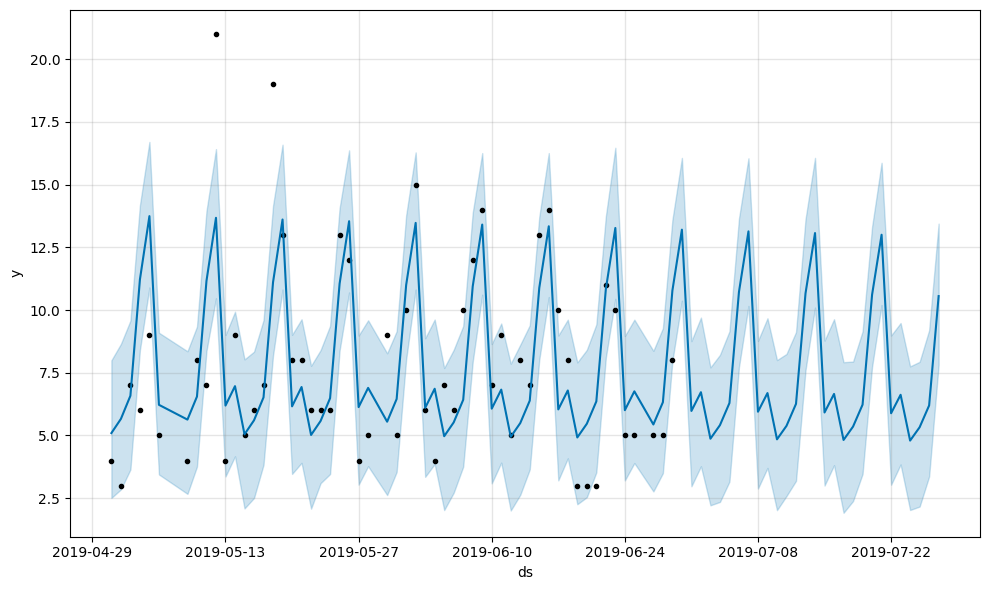

In [14]:
# Get the pickup location for the best model
sample_location_id = final_df.index[0]

# Get the algorithm used
sample_algorithm = final_df.loc[[sample_location_id]].algorithm.values[0]

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]
print(f"checkpoint type:: {type(checkpoint)}")

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()["model"]

# Restore already-created predictions from model training and eval
forecast_df = checkpoint.to_dict()["forecast_df"]

# Print pickup location ID, algorithm used, and model validation error.
sample_error = final_df.loc[[sample_location_id]].error.values[0]
print(
    f"location {sample_location_id}, algorithm {sample_algorithm}, best error {sample_error}"
)

# Plot forecast prediction using best model for this pickup location ID.
# If prophet model, use prophet built-in plot
if sample_algorithm == "arima":
    forecast_df[["trend", "yhat"]].plot()
else:
    plot1 = sample_model.plot(forecast_df)

checkpoint type:: <class 'ray.air.checkpoint.Checkpoint'>
location 141, algorithm arima, best error 342.35020228794644


/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:861: UserWarning: possible convergence problem: minimize gave code 1]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:861: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:861: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:861: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:861: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(


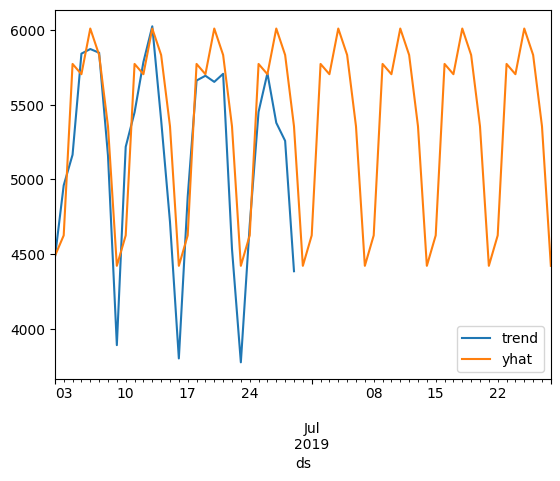

In [21]:
# Get the pickup location for the worst model
sample_location_id = final_df.index[len(final_df) - 2]

# Get the algorithm used
sample_algorithm = final_df.loc[[sample_location_id]].algorithm.values[0]

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]
print(f"checkpoint type:: {type(checkpoint)}")

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()["model"]

# Make a prediction using the restored model.
prediction = (
    sample_model.forecast(2 * (FORECAST_LENGTH + 1))
    .reset_index()
    .set_index("ds")
)
prediction["trend"] = None
prediction.rename(columns={"AutoARIMA": "yhat"}, inplace=True)
prediction = prediction.tail(FORECAST_LENGTH + 1)

# Restore already-created inferences from model training and eval
forecast_df = checkpoint.to_dict()["forecast_df"]

# Append the prediction to the inferences
forecast_df = pd.concat([forecast_df, prediction])
    
# Print pickup location ID, algorithm used, and model validation error.
sample_error = final_df.loc[[sample_location_id]].error.values[0]
print(
    f"location {sample_location_id}, algorithm {sample_algorithm}, best error {sample_error}"
)

# Plot forecast prediction using best model for this pickup location ID.
if sample_algorithm == "arima":
    forecast_df[["trend", "yhat"]].plot()
else:
    plot1 = sample_model.plot(forecast_df)

## Deploy the model from checkpoint using Ray Serve

In [ ]:
from fastapi import Request
from ray import serve
from ray.train.batch_predictor import BatchPredictor
from ray.serve import PredictorDeployment
from ray.serve.http_adapters import json_request

print(type(sample_model))
print(type(prediction))

# Create a BatchPredictor from the restored model and specify a Predictor class.
# Following example:  https://docs.ray.io/en/master/ray-air/key-concepts.html#batch-predictor
batch_predictor = BatchPredictor.from_checkpoint(
    checkpoint=sample_model, 
    predictor_cls="ForecastPredictor"
)

# Deploy the model as an inference service by using Ray Serve and the PredictorDeployment class.
async def adapter(request: Request):
    content = await request.json()
    print(content)
    return pd.DataFrame.from_dict(content)

# TODO modify this class to perform ARIMA or Prophet predictions?
@serve.deployment(route_prefix="/")
class ForecastPredictor:
    def __init__(self, name, model):
        self.name = name
        self._model = model

    def __call__(self):
        return f"Hello from {self.name}! " + self.model.forward()

# THIS DOES NOT WORK
# Deploy the best checkpoint as a live endpoint using PredictorDeployment.
serve.run(
    PredictorDeployment.options(
        name="ForecastService", num_replicas=2, route_prefix="/rayair"
    ).bind(
        ForecastPredictor, sample_model, batching_params=False, http_adapter=adapter
    )
)
# ERROR 2023-01-03 13:09:04,924 controller 12574 deployment_state.py:477 - Exception in deployment 'ForecastService'
# (ServeController pid=12574) Traceback (most recent call last):
# (ServeController pid=12574)   File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/serve/_private/deployment_state.py", line 468, in check_ready
# (ServeController pid=12574)     deployment_config, version = ray.get(self._ready_obj_ref)
# (ServeController pid=12574)   File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
# (ServeController pid=12574)     return func(*args, **kwargs)
# (ServeController pid=12574)   File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/_private/worker.py", line 2309, in get
# (ServeController pid=12574)     raise value.as_instanceof_cause()
# (ServeController pid=12574) ray.exceptions.RayTaskError(TypeError): ray::ServeReplica:ForecastService.reconfigure() (pid=17069, ip=172.31.187.140, repr=<ray.serve._private.replica.ServeReplica:ForecastService object at 0x7f10bc14b3d0>)
# (ServeController pid=12574)   File "/home/ray/anaconda3/lib/python3.8/concurrent/futures/_base.py", line 437, in result
# (ServeController pid=12574)     return self.__get_result()
# (ServeController pid=12574)   File "/home/ray/anaconda3/lib/python3.8/concurrent/futures/_base.py", line 389, in __get_result
# (ServeController pid=12574)     raise self._exception
# (ServeController pid=12574)   File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/serve/_private/replica.py", line 224, in reconfigure
# (ServeController pid=12574)     await self._initialize_replica()
# (ServeController pid=12574)   File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/serve/_private/replica.py", line 146, in initialize_replica
# (ServeController pid=12574)     await sync_to_async(_callable.__init__)(*init_args, **init_kwargs)
# (ServeController pid=12574)   File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/serve/air_integrations.py", line 267, in __init__
# (ServeController pid=12574)     predictor_cls = _load_predictor_cls(predictor_cls)
# (ServeController pid=12574)   File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/serve/air_integrations.py", line 53, in _load_predictor_cls
# (ServeController pid=12574)     if Predictor is not None and not issubclass(predictor_cls, Predictor):
# (ServeController pid=12574)   File "/home/ray/anaconda3/lib/python3.8/abc.py", line 102, in __subclasscheck__
# (ServeController pid=12574)     return _abc_subclasscheck(cls, subclass)
# (ServeController pid=12574) TypeError: issubclass() arg 1 must be a class


# After deploying the service, you can send requests to it.

# import requests

# TODO modify the json to just request future time steps for the forecast predictor
# sample_input = test_dataset.take(1)
# sample_input = dict(sample_input[0])

# output = requests.post("http://localhost:8000/", json=[sample_input]).json()
# print(output)
